# Proyek Klasifikasi Gambar: Vegetable Image Dataset
- **Nama:** Vania Rachmawati Dewi
- **Email:** vaniardewi@gmail.com
- **ID Dicoding:** vaniard

## Import Semua Packages/Library yang Digunakan

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image

In [2]:
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [5]:
import os
from google.colab import drive
base_dir = "/Klasifikasi CNN"

if not os.path.exists(base_dir):
    print("Folder Klasifikasi CNN tidak ditemukan!")
else:
    os.chdir(base_dir)

In [6]:
import kagglehub

path = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/vegetable-image-dataset


In [7]:
img_width = 180
img_height = 180
batch_size = 32

### Data Preprocessing

#### Split Dataset

In [8]:
data_train_path = '/kaggle/input/vegetable-image-dataset/Vegetable Images/train'
data_test_path = '/kaggle/input/vegetable-image-dataset/Vegetable Images/test'
data_val_path = '/kaggle/input/vegetable-image-dataset/Vegetable Images/validation'

In [9]:
import kagglehub
path = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")
print("Path to dataset files:", path)

data_train_path = os.path.join(path, "Vegetable Images/train")
data_test_path = os.path.join(path, "Vegetable Images/test")
data_val_path = os.path.join(path, "Vegetable Images/validation")

import tensorflow as tf

data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=42
)

Path to dataset files: /kaggle/input/vegetable-image-dataset
Found 15000 files belonging to 15 classes.
Using 12000 files for training.


In [10]:
data_category = data_train.class_names
data_category

['Bean',
 'Bitter_Gourd',
 'Bottle_Gourd',
 'Brinjal',
 'Broccoli',
 'Cabbage',
 'Capsicum',
 'Carrot',
 'Cauliflower',
 'Cucumber',
 'Papaya',
 'Potato',
 'Pumpkin',
 'Radish',
 'Tomato']

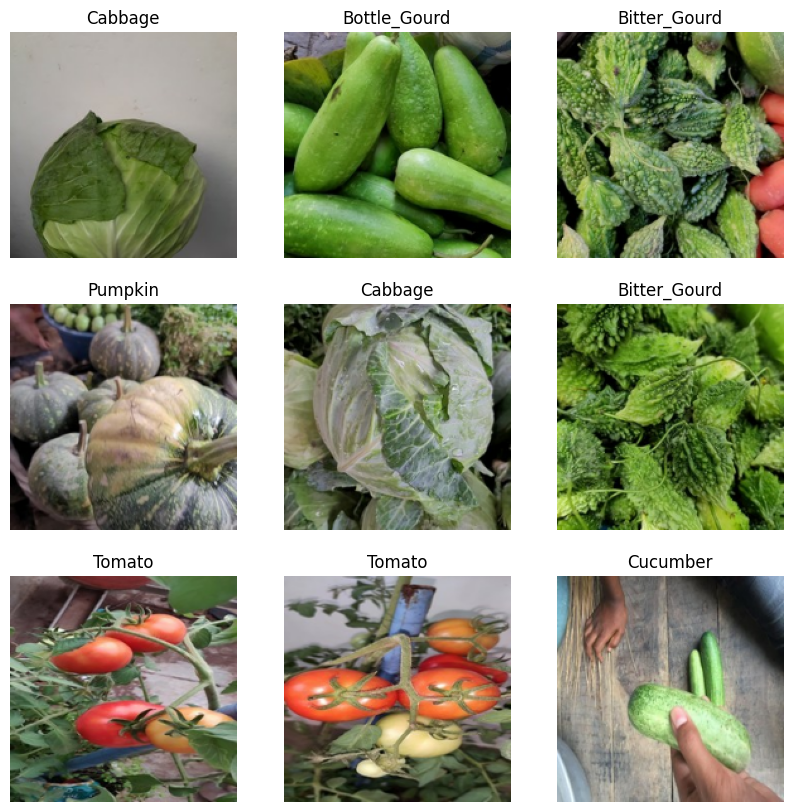

In [11]:
plt.figure(figsize=(10, 10))
for image, labels in data_train.take(1):
  for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(data_category[labels[i]])
    plt.axis('off')

In [12]:
data_val = tf.keras.utils.image_dataset_from_directory(
    data_val_path,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=42
)

Found 3000 files belonging to 15 classes.
Using 600 files for validation.


In [13]:
data_test = tf.keras.utils.image_dataset_from_directory(
    data_test_path,
    image_size=(img_height, img_width),
    shuffle=False,
    batch_size=batch_size
)

Found 3000 files belonging to 15 classes.


In [14]:
data_augmentasi = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomCrop(height=180, width=180),
])

data_train = data_train.map(lambda x, y: (data_augmentasi(x, training=True,), y))

## Modelling

### Rescalling Data

In [15]:
normalization_layer = layers.Rescaling(1./255)

data_train = data_train.map(lambda x, y: (normalization_layer(x), y))
data_val = data_val.map(lambda x, y: (normalization_layer(x), y))
data_test = data_test.map(lambda x, y: (normalization_layer(x), y))

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
data_train = data_train.prefetch(buffer_size=AUTOTUNE)
data_val = data_val.prefetch(buffer_size=AUTOTUNE)
data_test = data_test.prefetch(buffer_size=AUTOTUNE)

### Model

In [17]:
model = Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(data_category), activation='softmax')  # Softmax untuk klasifikasi
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [19]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

callbacks = [early_stop, reduce_lr]

In [20]:
epochs_size = 25 #25 epoch
history = model.fit(data_train, validation_data=data_val, epochs=epochs_size, callbacks=callbacks)

Epoch 1/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 149s 374ms/step - accuracy: 0.2425 - loss: 3.1320 - val_accuracy: 0.1217 - val_loss: 5.4363 - learning_rate: 0.0010
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 189s 355ms/step - accuracy: 0.3643 - loss: 1.8771 - val_accuracy: 0.5900 - val_loss: 1.2491 - learning_rate: 0.0010
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 134s 357ms/step - accuracy: 0.4361 - loss: 1.6373 - val_accuracy: 0.5100 - val_loss: 1.3287 - learning_rate: 0.0010
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 136s 364ms/step - accuracy: 0.4918 - loss: 1.4574 - val_accuracy: 0.6217 - val_loss: 1.0962 - learning_rate: 0.0010
Epoch 5/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 141s 361ms/step - accuracy: 0.5299 - loss: 1.3293 - val_accuracy: 0.7133 - val_loss: 0.8134 - learning_rate: 0.0010
Epoch 6/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 142s 360ms/step - accuracy: 0.5625 - loss: 1.2286 - val_accuracy: 0.6917 - val_loss: 0.8432 - learning_rate: 0.0010
Epoch 7/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 135s 359ms/step - accura

## Evaluasi dan Visualisasi

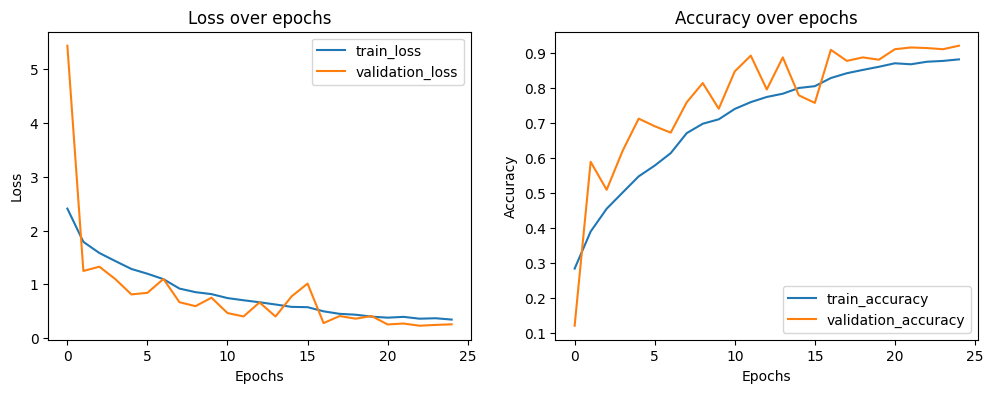

In [21]:
def plot_loss_accuracy(history):
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='train_loss')
  plt.plot(history.history['val_loss'], label='validation_loss')
  plt.title('Loss over epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='train_accuracy')
  plt.plot(history.history['val_accuracy'], label='validation_accuracy')
  plt.title('Accuracy over epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

plot_loss_accuracy(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━

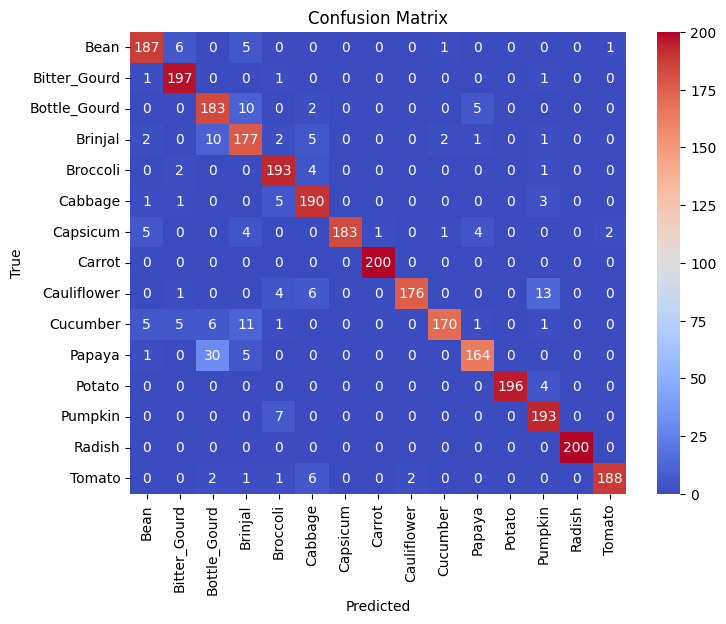

Classification Report:
              precision    recall  f1-score   support

        Bean       0.93      0.94      0.93       200
Bitter_Gourd       0.93      0.98      0.96       200
Bottle_Gourd       0.79      0.92      0.85       200
     Brinjal       0.83      0.89      0.86       200
    Broccoli       0.90      0.96      0.93       200
     Cabbage       0.89      0.95      0.92       200
    Capsicum       1.00      0.92      0.96       200
      Carrot       1.00      1.00      1.00       200
 Cauliflower       0.99      0.88      0.93       200
    Cucumber       0.98      0.85      0.91       200
      Papaya       0.94      0.82      0.87       200
      Potato       1.00      0.98      0.99       200
     Pumpkin       0.89      0.96      0.93       200
      Radish       1.00      1.00      1.00       200
      Tomato       0.98      0.94      0.96       200

    accuracy                           0.93      3000
   macro avg       0.94      0.93      0.93      3000
wei

In [22]:
def plot_confusion_matrix(model, data_test):
  y_true = np.concatenate([y.numpy() for x, y in data_test], axis=0)
  y_predict = np.concatenate([np.argmax(model.predict(x), axis=1) for x, _ in data_test], axis=0)

  confusion_matrixes = confusion_matrix(y_true, y_predict)
  plt.figure(figsize=(8, 6))
  sns.heatmap(confusion_matrixes, annot=True, fmt='d', cmap='coolwarm', xticklabels=data_category, yticklabels=data_category)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

  print('Classification Report:')
  print(classification_report(y_true, y_predict, target_names=data_category))

plot_confusion_matrix(model, data_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9351 - loss: 0.2013
Test Accuracy: 0.9323, Test Loss: 0.2212
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


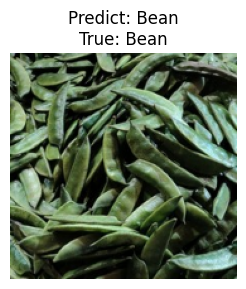

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


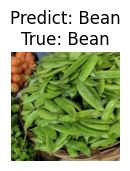

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


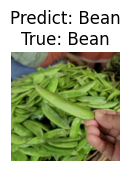

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


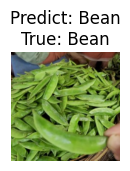

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


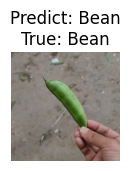

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


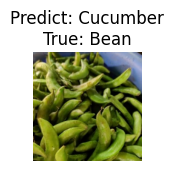

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


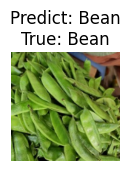

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


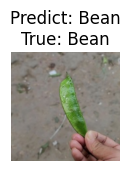

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


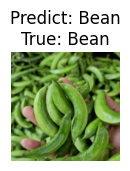

In [23]:
import random

def plot_prediction(model, data_test):
  class_names = data_category
  plt.figure(figsize=(10, 10))

  for images, labels in data_test.take(1):
    indices = random.sample(range(len(images)), 9)
    for i, idx in enumerate(indices):
      ax = plt.subplot(3, 3, i+1)

      img = images[idx].numpy()
      img = np.clip(img * 255, 0, 255).astype('uint8')

      plt.imshow(img)

      predicted_label = np.argmax(model.predict(tf.expand_dims(images[idx], axis=0)))
      plt.title(f'Predict: {class_names[predicted_label]}\nTrue: {class_names[labels[idx]]}')
      plt.axis('off')

      plt.show()

test_loss, test_acc = model.evaluate(data_test)
print(f'Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}')

plot_prediction(model, data_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


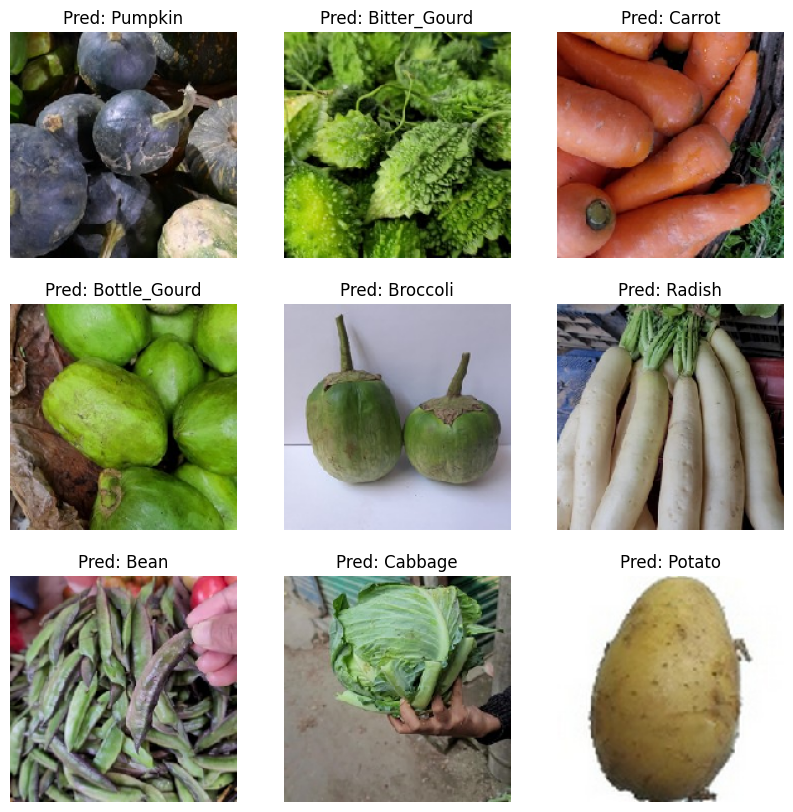

In [25]:
from tensorflow.keras.utils import load_img, img_to_array

def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array
def plot_predictions_from_folder_with_classes(model, folder_path):
    class_names = os.listdir(folder_path)
    img_paths = []

    for class_name in class_names:
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            img_files = [os.path.join(class_folder, fname) for fname in os.listdir(class_folder) if fname.endswith(('png', 'jpg', 'jpeg'))]
            img_paths.extend(img_files)

    random_img_paths = random.sample(img_paths, 9)

    plt.figure(figsize=(10, 10))
    for i, img_path in enumerate(random_img_paths):
        img_array = load_and_preprocess_image(img_path)
        prediction = model.predict(img_array)
        pred_label = np.argmax(prediction)

        ax = plt.subplot(3, 3, i + 1)
        img = load_img(img_path, target_size=(img_width, img_height))
        plt.imshow(img)
        plt.title(f"Pred: {data_category[pred_label]}")
        plt.axis('off')

    plt.show()

plot_predictions_from_folder_with_classes(model, data_test_path)


In [30]:
from tensorflow.keras.utils import load_img, img_to_array

def load_and_preprocess_image(img_path):

    img = load_img(img_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

def plot_predictions_from_folder(model, folder_path):
    img_paths = [os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith(('png', 'jpg', 'jpeg'))]

    num_samples = min(len(img_paths), 9)

    random_img_paths = random.sample(img_paths, num_samples)

    plt.figure(figsize=(10, 10))

    for i, img_path in enumerate(random_img_paths):
        img_array = load_and_preprocess_image(img_path)
        prediction = model.predict(img_array)
        pred_label = np.argmax(prediction)

        ax = plt.subplot(3, 3, i + 1)

        img = load_img(img_path, target_size=(img_width, img_height))
        plt.imshow(img)
        plt.title(f"Pred: {data_category[pred_label]}")
        plt.axis('off')

    plt.show()

plot_predictions_from_folder(model, data_test_path)

<Figure size 1000x1000 with 0 Axes>

## Konversi Model

In [35]:
import tensorflow as tf

saved_model_dir = "/content/saved_model"

model.export(saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

os.makedirs('tflite', exist_ok=True)

label_kelas = {
    0: 'Bean',
    1: 'Bitter_Gourd',
    2: 'Bottle_Gourd',
    3: 'Brinjal',
    4: 'Broccoli',
    5: 'Cabbage',
    6: 'Capsicum',
    7: 'Carrot',
    8: 'Cauliflower',
    9: 'Cucumber',
    10: 'Papaya',
    11: 'Potato',
    12: 'Pumpkin',
    13: 'Radish',
    14: 'Tomato'
}

with open('tflite/labels.txt', 'w') as f:
    for key, value in label_kelas.items():
        f.write(f"{key} {value}\n")

with tf.io.gfile.GFile('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/content/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor_8')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  134491200972240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134491200973968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134491200976080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134491200976464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134491200975312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134491200975696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134491200974544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134491200977424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134491200978576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134491200977232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1344912

In [37]:
pip install tensorflowjs==4.18.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [38]:
!tensorflowjs_converter --input_format=tf_saved_model  /content/saved_model /content/tfjs_model

2025-05-14 09:06:35.386084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747213595.406629   26508 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747213595.413158   26508 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-14 09:06:46.043051: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1747213606.043266   26508 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

## Inference (Optional)

Saving potato.jpg to potato (1).jpg


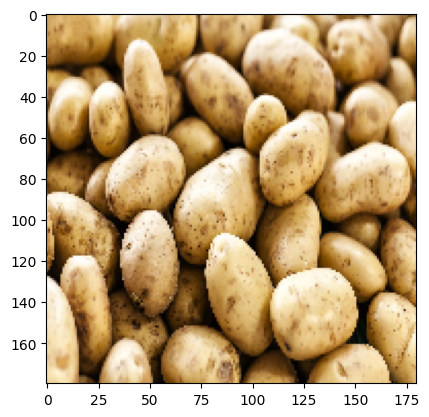

Kelas yang Diprediksi: Potato, Tingkat Keyakinan: 100.00%


In [48]:
from google.colab import files
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

uploaded = files.upload()

image_path = list(uploaded.keys())[0]

img = image.load_img(image_path, target_size=(180, 180))

plt.imshow(img)
plt.show()

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

model_path = 'tflite/model.tflite'

if not os.path.exists(model_path):
    print(f"Error: Model file not found at {model_path}")
else:
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    interpreter.set_tensor(input_details[0]['index'], x)

    interpreter.invoke()

    predictions = interpreter.get_tensor(output_details[0]['index'])

    predicted_class = np.argmax(predictions)
    confidence = predictions[0][predicted_class] * 100

    label_kelas = { 0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Pumkin', 12: 'Potato', 13:  'Radish', 14: 'Tomato'}
    label_prediksi = label_kelas[predicted_class]

    print(f"Kelas yang Diprediksi: {label_prediksi}, Tingkat Keyakinan: {confidence:.2f}%")

In [49]:
shutil.make_archive('/content/Submission', 'zip', '/content')

'/content/Submission.zip'

In [51]:
!pip freeze > requirements.txt